# Review of Statistics

This notebook shows some basic statistics needed for a course in financial econometrics.

It uses the Statistics package (built in) for descriptive statistics (averages, autocorrelations, etc) and the [Distributions](https://github.com/JuliaStats/Distributions.jl)  package for statistical distributions (pdf, cdf, etc).

## Load Packages

In [1]:
                         
include("jlFiles/printmat.jl")   #prettier matrix printing

printyellow (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))           #use pyplot() or gr()
gr(size=(480,320))
default(fmt = :svg)

# Distributions

## Probability Density Function (pdf)

The cells below calculate and plot some pdfs. The Distributions package has many more distributions.

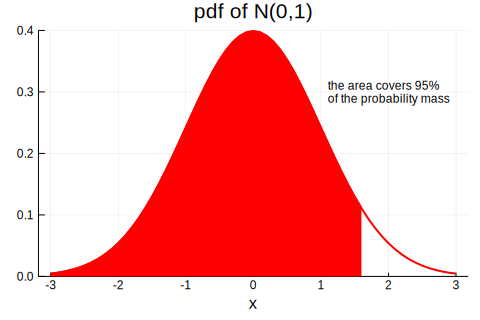

In [3]:
x  = -3:0.1:3
xb = x[x.<=1.645]

pdfx  = pdf.(Normal(0,1),x)       #calculate the pdf of a N(0,1) variable
pdfxb = pdf.(Normal(0,1),xb)

p1 = plot(x,pdfx,color=:red,linewidth=2,legend=nothing,ylims=(0,0.4))  #plot pdf
plot!(xb,pdfxb,color=:red,linewidth=2,legend=nothing,fill=(0,:red))    #plot area under pdf
title!("pdf of N(0,1)")
xlabel!("x")
annotate!(1.1,0.3,text("the area covers 95%\n of the probability mass",:left,8))

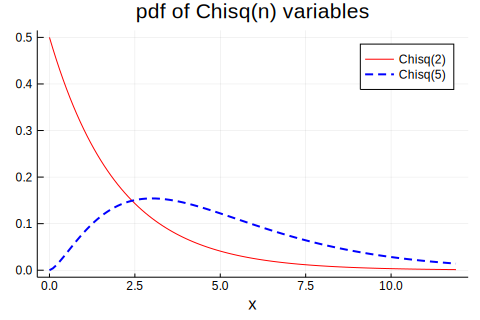

In [4]:
x  = 0.0001:0.1:12

pdf2  = pdf.(Chisq(2),x)    
pdf5 =  pdf.(Chisq(5),x)

p1 = plot(x,pdf2,color=:red,label="Chisq(2)")  
plot!(x,pdf5,color=:blue,line=(:dash,2),label="Chisq(5)") 
title!("pdf of Chisq(n) variables")
xlabel!("x")

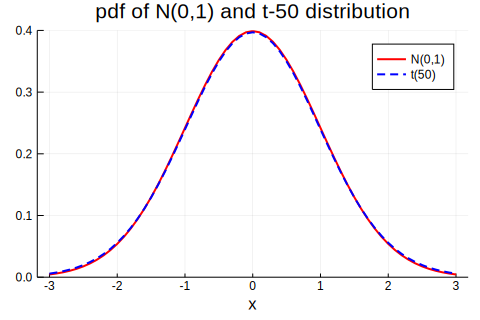

In [5]:
x  = -3:0.1:3

p1 = plot(x,pdf.(Normal(0,1),x),color=:red,linewidth=2,label="N(0,1)",ylims=(0,0.4))
plot!(x,pdf.(TDist(50),x),color=:blue,line=(:dash,2),label="t(50)")
title!("pdf of N(0,1) and t-50 distribution")
xlabel!("x")
ylabel!("")

## Cumulative Distribution Function (cdf)

and probabilities for different outcomes.

Notice that Distributions package wants Normal($\mu,\sigma$), not Normal($\mu,\sigma^2$).

In [6]:
printblue("Probability of:\n")
printlnPs("x<=-1.645 when x is N(0,1) ",cdf(Normal(0,1),-1.645))
printlnPs("x<=0 when x is N(0,1)      ",cdf(Normal(0,1),0))
printlnPs("2<x<=3 when x is N(0,2)    ",cdf(Normal(0,sqrt(2)),3)-cdf(Normal(0,sqrt(2)),2))
printlnPs("2<x<=3 when x is N(1,2)    ",cdf(Normal(1,sqrt(2)),3)-cdf(Normal(1,sqrt(2)),2))

printlnPs("\nx>4.61 when x is Chisq(2)  ",cdf(Chisq(2),4.61))
printlnPs("x>9.24 when x is Chisq(5)  ",cdf(Chisq(5),9.24))

Probability of:

x<=-1.645 when x is N(0,1)      0.050
x<=0 when x is N(0,1)           0.500
2<x<=3 when x is N(0,2)         0.062
2<x<=3 when x is N(1,2)         0.161

x>4.61 when x is Chisq(2)       0.900
x>9.24 when x is Chisq(5)       0.900


## Quantiles

...inverting the cdf

In [7]:
N05     = quantile(Normal(0,1),0.1)            #from the Distributions package
Chisq05 = quantile(Chisq(5),0.9)

printblue("\n10th percentiles:")
printlnPs("of a N(0,1)      ",N05)
printlnPs("of a Chisquare(5)",Chisq05)


10th percentiles:
of a N(0,1)          -1.282
of a Chisquare(5)     9.236


## Confidence Bands and t-tests

In [8]:
β = 0.5                                         #an estimate (a random variable)
σ = 0.15                                        #std of the estimate   
confB = [(β-1.64*σ) (β+1.64*σ)]                 #confidence band of the estimate

println("90% confidence band for N(β,σ^2) with β=$β and σ=$σ:  ",confB)

90% confidence band for N(β,σ^2) with β=0.5 and σ=0.15:  [0.254 0.746]


In [9]:
tstat1 = (β - 0.4)/σ      #testing H₀: coefficient is 0.4
tstat2 = (β - 0.746)/σ    #testing H₀: coefficient is 0.746
tstat3 = (β - 1)/σ        #testing H₀: coefficient is 1.0

println("t-stats: are they beyond [-1.64,1.64]?")
printmat([tstat1 tstat2 tstat3])

t-stats: are they beyond [-1.64,1.64]?
     0.667    -1.640    -3.333



## Load Data from a csv File

In [10]:
x = readdlm("Data/FFmFactorsPs.csv",',',skipstart=1)

                #yearmonth, market, small minus big, high minus low
(ym,Rme,RSMB,RHML) = [x[:,i] for i=1:4] 
ym = round.(Int,ym)      

println("Sample period: ",ym[1],"-",ym[end])

Sample period: 197901-201104


## Means and Standard Deviations

In [11]:
xbar = mean([Rme RHML],dims=1)    #,dims=1 to calculate average along a column
s    = std([Rme RHML],dims=1)     #do \sigma[Tab] to get σ
T    = length(Rme)


println("               Rme       RHML")
printlnPs("means: ",xbar)  #for more stat functions, see the package StatsBase.jl
printlnPs("std:   ",s)

               Rme       RHML
   means:      0.602     0.330
   std:        4.604     3.127


In [12]:
println("std of sample averages (assuming iid data): ")
printmat(s/sqrt(T))

std of sample averages (assuming iid data): 
     0.234     0.159



## Skewness, Kurtosis and Bera-Jarque

In [13]:
xStd     = (Rme .- mean(Rme))./std(Rme)
skewness = mean(xStd.^3)
kurtosis = mean(xStd.^4)

BJ     = (T/6)*skewness.^2 + (T/24)*(kurtosis.-3).^2  #Chisq(2)
pvalBJ = 1 .- cdf.(Chisq(2),BJ)

println("Skewness, kurtosis and Bera-Jarque")
printmat([skewness,kurtosis,BJ])

Skewness, kurtosis and Bera-Jarque
    -0.806
     5.347
   131.128



## Covariances and Correlations

In [14]:
println("\ncov([Rme RHML]): ")          
printmat(cov([Rme RHML]))

println("\ncor([Rme RHML]): ")          
printmat(cor([Rme RHML]))

ρ = cor(Rme,RHML)
tstat = T*ρ/sqrt(1-ρ^2)

printlnPs("correlation and its t-stat:",ρ,tstat)


cov([Rme RHML]): 
    21.197    -4.875
    -4.875     9.775


cor([Rme RHML]): 
     1.000    -0.339
    -0.339     1.000

correlation and its t-stat:    -0.339  -139.650
